# Summary of Data

Let's start by loading the data.

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from bestreads.dataset_ops import convert_str_array

In [2]:
data = pd.read_csv('../data/goodreads_books.csv')
data.head()

,id,title,link,series,cover_link,author,author_link,rating_count,review_count,average_rating,...,isbn13,asin,settings,characters,awards,amazon_redirect_link,worldcat_redirect_link,recommended_books,books_in_series,description
0,630104,Inner Circle,https://www.goodreads.com//book/show/630104.In...,(Private #5),https://i.gr-assets.com/images/S/compressed.ph...,"Kate Brian, Julian Peploe",https://www.goodreads.com/author/show/94091.Ka...,7597,196,4.03,...,9781416950417,NaN,NaN,NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"726458, 726458, 1537534, 3047848, 1651302, 304...","381489, 381501, 352428, 630103, 1783281, 17832...",Reed Brennan arrived at Easton Academy expecti...
1,9487,A Time to Embrace,https://www.goodreads.com//book/show/9487.A_Ti...,(Timeless Love #2),https://i.gr-assets.com/images/S/compressed.ph...,Karen Kingsbury,https://www.goodreads.com/author/show/3159984....,4179,177,4.35,...,9781595542328,NaN,NaN,NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"127352, 127352, 40642197, 127353, 127354, 3891...",115036,"Ideje az Ã¶lelÃ©snek TÃ¶rtÃ©net a remÃ©nyrÅl,..."
2,6050894,Take Two,https://www.goodreads.com//book/show/6050894-t...,(Above the Line #2),https://i.gr-assets.com/images/S/compressed.ph...,Karen Kingsbury,https://www.goodreads.com/author/show/3159984....,6288,218,4.23,...,NaN,NaN,"Bloomington, Indiana(United States)",NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"706250, 706250, 666481, 11942636, 706241, 1273...","4010795, 40792877, 7306261",Filmmakers Chase Ryan and Keith Ellison have c...
3,39030,Reliquary,https://www.goodreads.com//book/show/39030.Rel...,(Pendergast #2),https://i.gr-assets.com/images/S/compressed.ph...,"Douglas Preston, Lincoln Child",https://www.goodreads.com/author/show/12577.Do...,38382,1424,4.01,...,9780765354952,NaN,"New York State(United States) New York City, N...","Aloysius X.L. Pendergast, Margo Green, William...",NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"39026, 39026, 11007668, 3986318, 51887330, 194...","67035, 39031, 39033, 136637, 136638, 30068, 39...",NaN
4,998,The Millionaire Next Door: The Surprising Secr...,https://www.goodreads.com//book/show/998.The_M...,NaN,https://i.gr-assets.com/images/S/compressed.ph...,"Thomas J. Stanley, William D. Danko",https://www.goodreads.com/author/show/659.Thom...,72168,3217,4.04,...,9780671015206,NaN,NaN,NaN,Independent Publisher Book Award (IPPY) Nomine...,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"1052, 1052, 763362, 69571, 78427, 30186948, 10...",NaN,The incredible national bestseller that is cha...


Now that we have read the data in properly, let's explore some of the values.  For example, we can see that there is a column where Goodreads recommends similar books.  Let's see what the distribution of the number of recommendations looks like!  First, we will need to write a function that can parse the book ID's into a list.

/home/adam/Documents/bestreads/bestreads/dataset_ops.py:42: RuntimeWarning: NaN value detected in convert_str_array(string)
  category=RuntimeWarning)


Text(0, 0.5, 'Frequency')

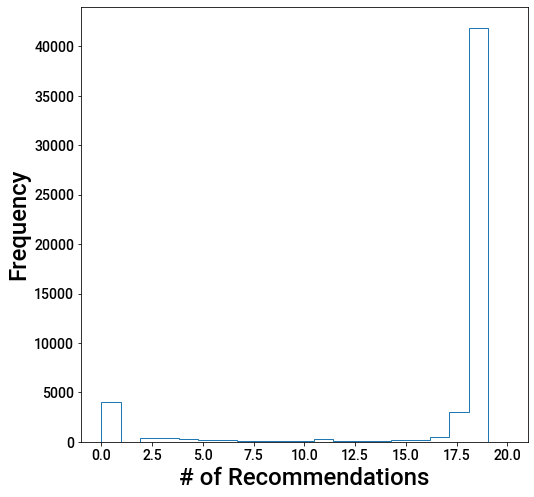

In [4]:
book_recommendations = []
for book_rec in data.recommended_books:
    book_recommendations.append(len(convert_str_array(book_rec)))

fig = plt.figure(figsize=(8, 8))
sp = fig.add_subplot(111)
sp.hist(book_recommendations, histtype='step', range=(0, 20), bins=(21))
sp.set_xlabel('# of Recommendations')
sp.set_ylabel('Frequency')

TypeError: object of type 'float' has no len()

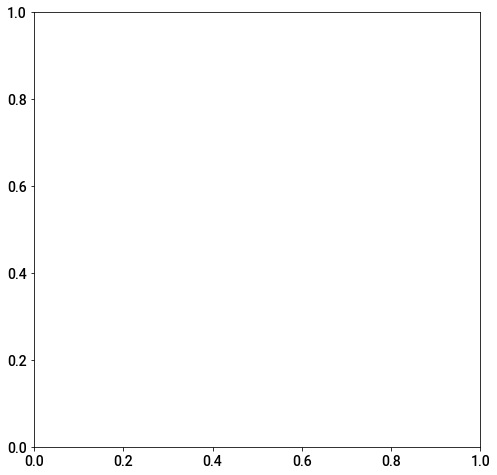

In [11]:
fig = plt.figure(figsize=(8, 8))
sp = fig.add_subplot(111)
sp.hist(data.recommended_books.apply(len), bins = 100)

sp.set_xlabel('Number of Recommendations')
sp.set_ylabel('Frequency')

In [13]:
data.recommended_books[0]

'726458, 726458, 1537534, 3047848, 1651302, 3047851, 561403, 162085, 3047849, 3047850, 162089, 9528186, 6443321, 9893331, 37487, 43207845, 37856897, 52589893, 37486'